В качестве набора данных мы будем использовать набор данных 
по классификации сорта риса - https://www.muratkoklu.com/datasets/ (Date Rice Dataset Cammeo and Osmancik)

Датасет состоит из файла, содержащего выборку данных - Rice_Cammeo_Osmancik.xlxs

Файл содержит следующие колонки:
- Area - количество пикселей на исходном изображении 
- Perimeter - периметр эллипса
- Major Axis Length - длина большой полуоси
- Minor Axis Length - длина малой полуоси
- Eccentricity - эксцентриситет
- Convex Area - количество пискелей выпуклой оболочки для риса
- Extent - отношение площади риса к площади всего исходного изображения
- Class - Commeo или Osmancik

Решим задачу построения модели бинарной классификации. (Целевой признак - Class)

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.axes
from sklearn.preprocessing import MinMaxScaler,  LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Загрузка данных

Загрузим файлы датасета в помощью библиотеки Pandas. 

In [2]:
original_data = pd.read_excel('Rice_Cammeo_Osmancik.xlsx', sheet_name='Rice')
# Удалим дубликаты записей, если они присутствуют
data = original_data.drop_duplicates()

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

### Основные характеристики датасетов

In [3]:
# Первые 5 строк датасета
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


In [4]:
# Размер обучающего датасета
data.shape

(3810, 8)

In [5]:
# Список колонок
data.columns

Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
       'Eccentricity', 'Convex_Area', 'Extent', 'Class'],
      dtype='object')

In [6]:
# Список колонок с типами данных 
data.dtypes

Area                   int64
Perimeter            float64
Major_Axis_Length    float64
Minor_Axis_Length    float64
Eccentricity         float64
Convex_Area            int64
Extent               float64
Class                 object
dtype: object

In [7]:
# Проверим наличие пустых значений
data.isnull().sum()

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64

**Вывод. Представленный набор данных не содержит пропусков ни в обучающей, ни в тестовой выборках.**

### Построение графиков для понимания структуры данных

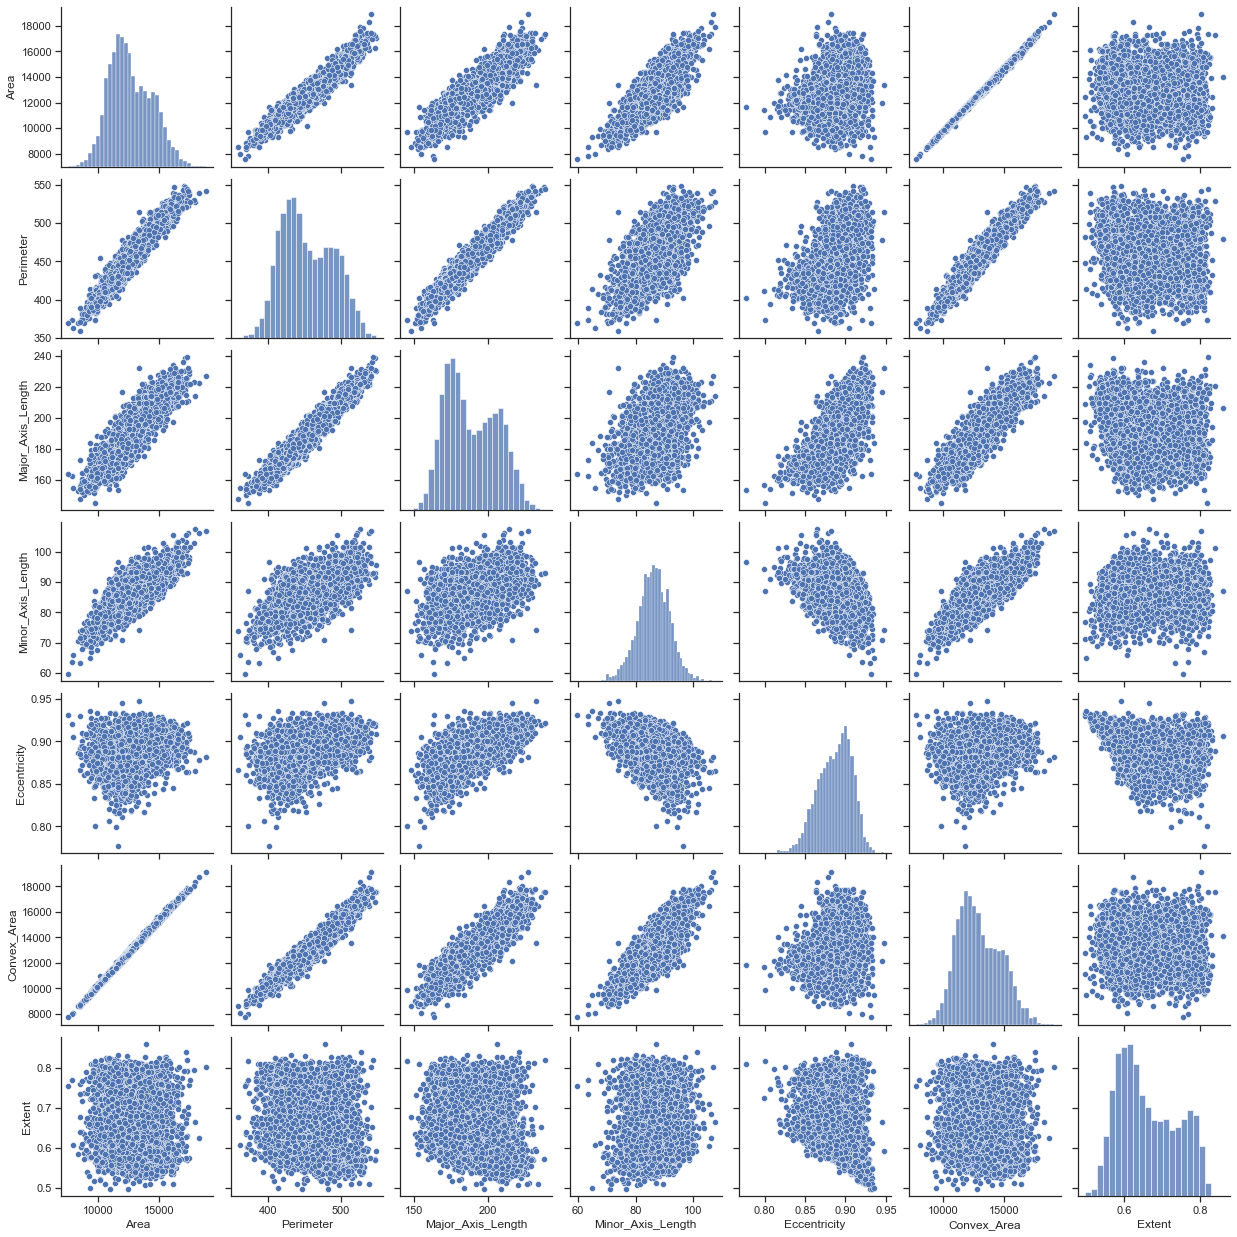

In [8]:
# Парные диаграммы
sns.pairplot(data)

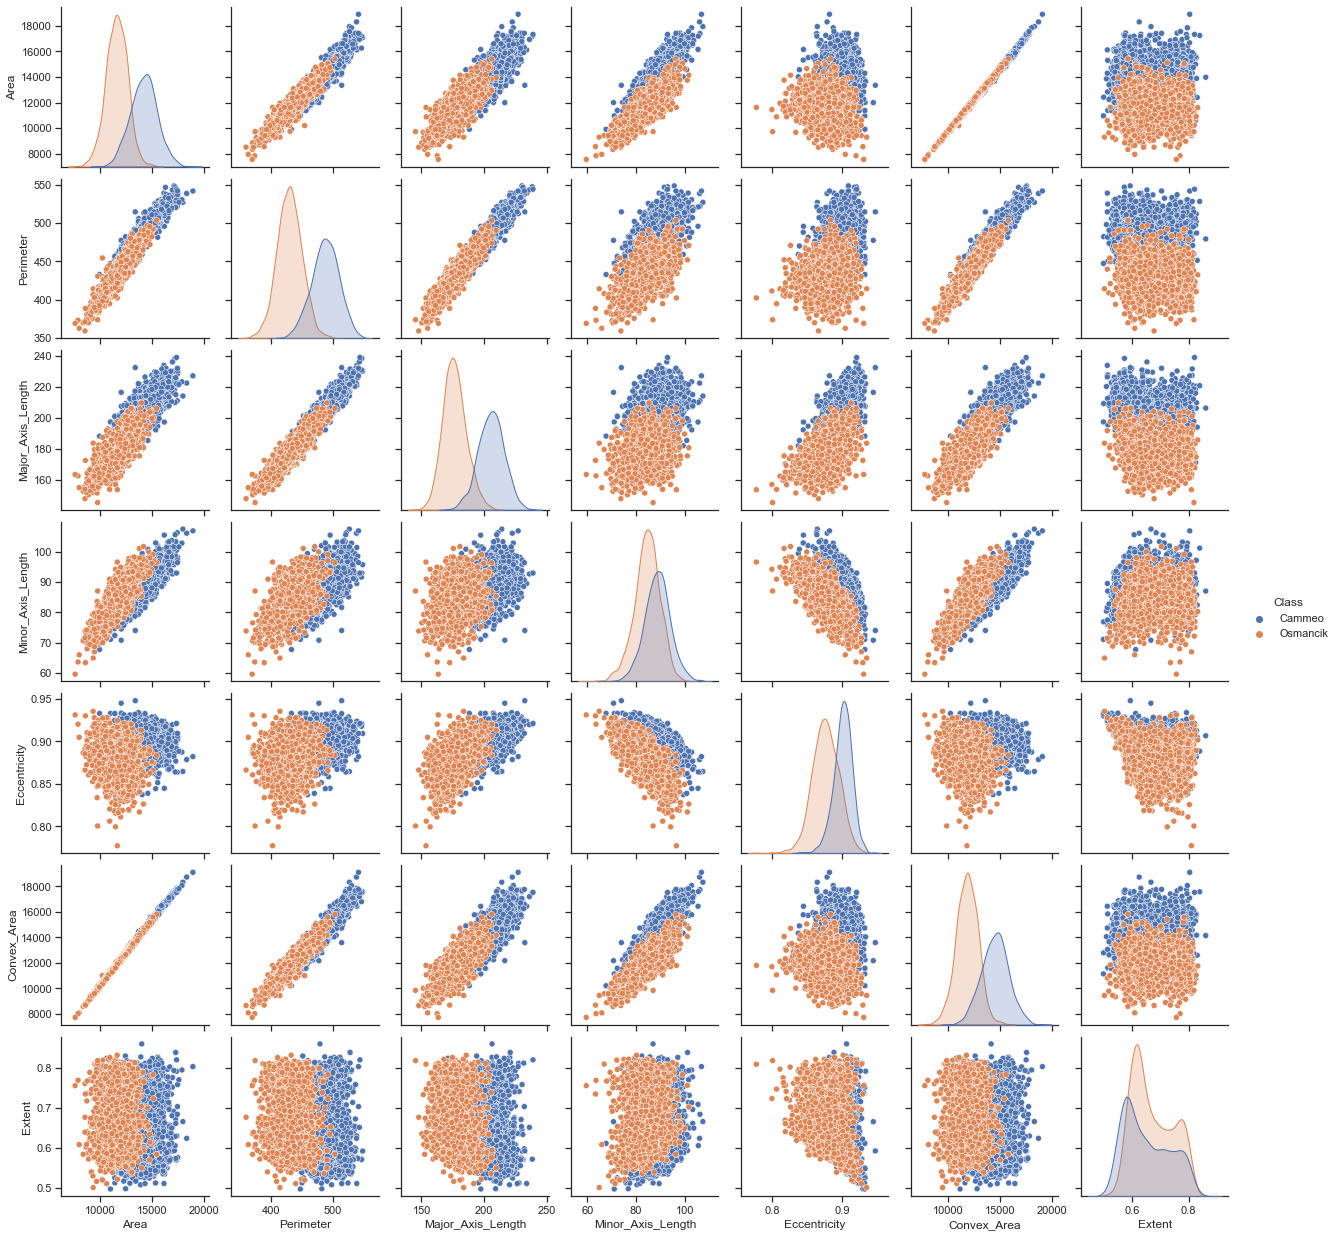

In [9]:
sns.pairplot(data, hue="Class")

In [10]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только два класса
data['Class'].unique()

array(['Cammeo', 'Osmancik'], dtype=object)

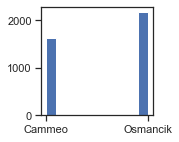

In [11]:
# Оценим дисбаланс классов
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(data['Class'])
plt.show()

In [12]:
data['Class'].value_counts()

Osmancik    2180
Cammeo      1630
Name: Class, dtype: int64

In [13]:
# посчитаем дисбаланс классов
total = data.shape[0]
class_0, class_1 = data['Class'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 57.220000000000006%, а класс 1 составляет 42.78%.


**Вывод. Присутствует незначительный дизбаланс классов**

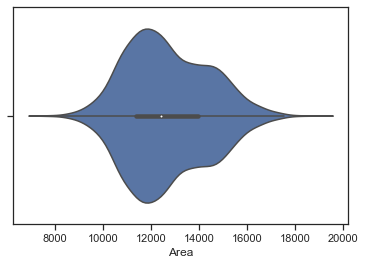

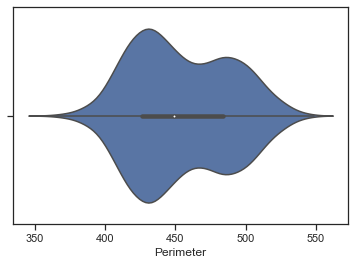

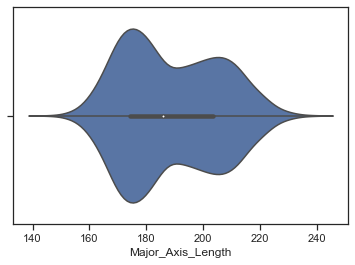

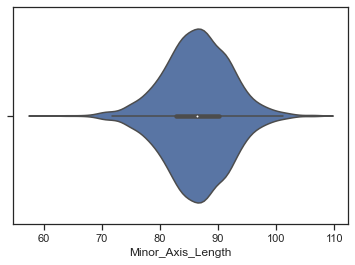

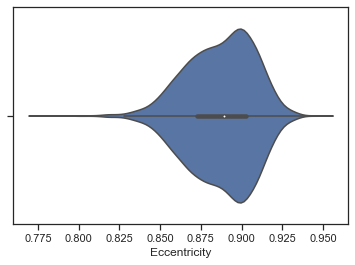

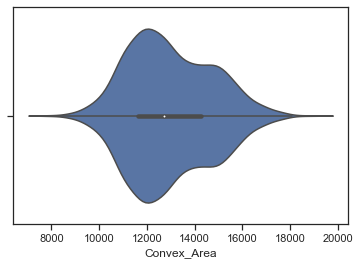

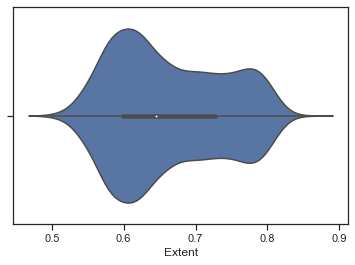

In [14]:
# Скрипичные диаграммы для числовых колонок
for col in data.columns:
    if (col == "Class"):
        continue

    sns.violinplot(x=data[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [15]:
data.dtypes

Area                   int64
Perimeter            float64
Major_Axis_Length    float64
Minor_Axis_Length    float64
Eccentricity         float64
Convex_Area            int64
Extent               float64
Class                 object
dtype: object

Для построения модели бинарной классификации будем использовать все признаки кроме признаков Area и Convex Area. Так как занимаемую площадь на изображении можно рассчитать из параметров Major_Axis_Length и Minor_Axis_Length данные поля являются лишними.

Категориальные признаки отсутствуют, их кодирования не требуется. Исключением является целевой признак Class.

Вспомогательные признаки для улучшения качества моделей строится не будут.

Выполним масштабирование данных.

### Кодирование категориального целевого признака

In [16]:
# Кодирование категориального целевого признака
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(data['Class'])
data_encoded = data.copy()
data_encoded['Class'] = class_encoded

In [17]:
data_encoded.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,0
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,0
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,0
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,0
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,0


In [18]:
# Проверим правильность кодировки
data_encoded['Class'].unique()

array([0, 1])

### Масштабирование данных

In [19]:
# Числовые колонки для масштабирования
scale_cols = ['Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity',
 'Extent']

sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [20]:
# Удалим ненужные колонки из данных
data_fixed = data_encoded.drop(columns=['Area', 'Convex_Area'])

In [21]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    data_fixed[col] = sc1_data[:,i]

In [22]:
data_fixed.head()

,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Extent,Class
0,0.879232,0.901216,0.532417,0.888011,0.207577,0
1,0.714095,0.648087,0.670663,0.691980,0.324564,0
2,0.750066,0.734349,0.588124,0.789846,0.538576,0
3,0.524136,0.512800,0.581461,0.671227,0.393954,0
4,0.781992,0.709138,0.620288,0.758067,0.408680,0


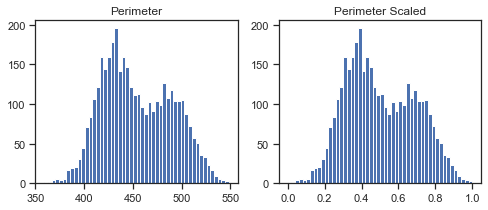

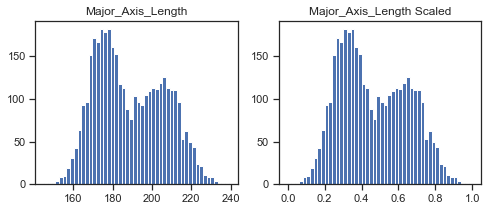

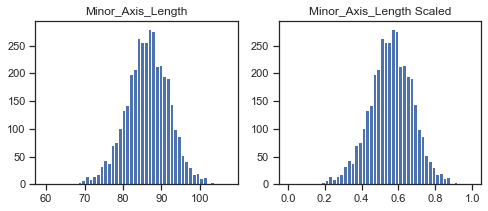

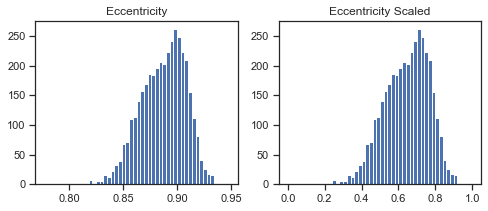

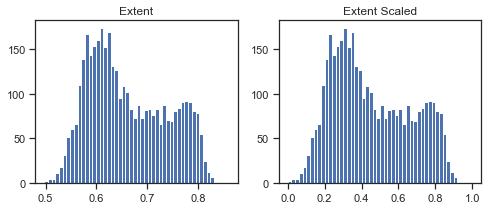

In [23]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data_fixed[col], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col + " Scaled")
    plt.show()

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

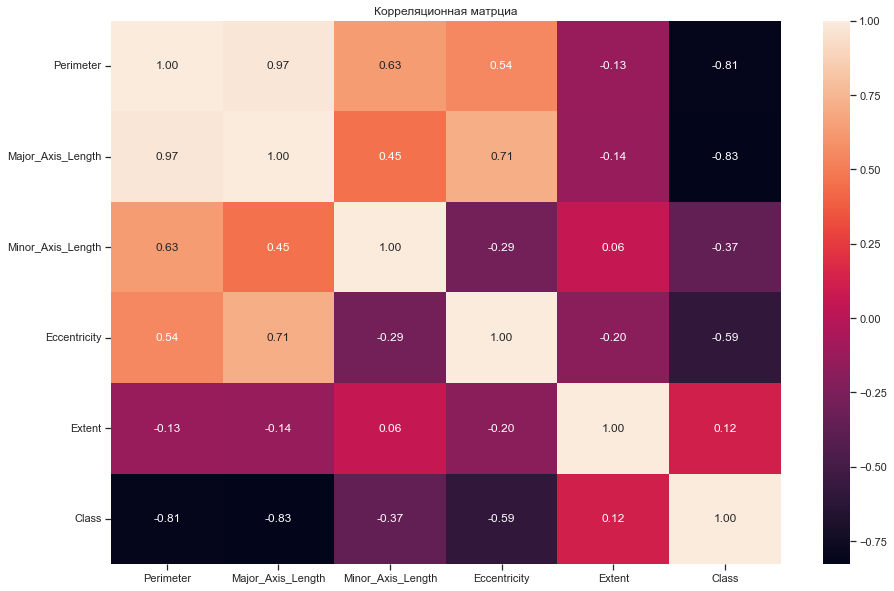

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_fixed.corr(), annot=True, fmt='.2f')
ax.set_title('Корреляционная матрциа')
plt.xticks(rotation = 0)
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

- Целевой признак классификации "Class" наиболее сильно коррелирует с периметром (-0.81), длиной большой полуоси (-0.83) и эксцентриситетом (-0.59).
- Признаки "Периметр" (Perimeter) и "Длина большой полуоси" (Major_Axis_Length) имеют сильную корреляцию (0.97), поэтому оба признака не будут включены в модель. Вместо этого будем использовать признак Major_Axis_Length, так как он лучше коррелирует с целевым признаком классификации.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком.  На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения. 

## Выбор метрик для последующей оценки качества моделей.

### В качестве метрик для решения задачи классификации  будем использовать:

Метрики, формируемые на основе матрицы ошибок:

#### Метрика precision:

Можно переводить как точность, но такой перевод совпадает с переводом метрики "accuracy".

$precision = \frac{TP}{TP+FP}$

Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

Используется функция [precision_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

#### Метрика recall (полнота):

$recall = \frac{TP}{TP+FN}$

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

Используется функция [recall_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

#### Метрика $F_1$-мера

Для того, чтобы объединить precision и recall в единую метрику используется $F_\beta$-мера, которая вычисляется как среднее гармоническое от precision и recall:

$F_\beta = (1+\beta^2) \cdot \frac{precision \cdot recall}{precision + recall}$

где $\beta$ определяет вес точности в метрике.

На практике чаще всего используют вариант F1-меры (которую часто называют F-мерой) при $\beta=1$:

$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

Для вычисления используется функция [f1_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

#### Метрика ROC AUC

Основана на вычислении следующих характеристик:

$TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция [roc_auc_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

### Сохранение и визуализация метрик

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [25]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,5)), color='white')
        plt.show()    

## Выбор наиболее подходящих моделей для решения задачи классификации.
Будем использовать следующие модели:
- Логистическая регрессия
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [26]:
# Размер всей выборки
data_fixed.shape

(3810, 6)

In [27]:
class_cols = ['Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity',
 'Extent']
class_Y = 'Class'

X_train, X_test, Y_train, Y_test = train_test_split(data_fixed[class_cols], 
    data_fixed[class_Y], test_size=0.2, random_state=1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3048, 5), (762, 5), (3048,), (762,))

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [28]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(probability=True),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [29]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [30]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [31]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(X_train, Y_train)
    # Предсказание значений
    Y_pred = model.predict(X_test)
    # Предсказание вероятности класса "1" для roc auc
    Y_pred_proba_temp = model.predict_proba(X_test)
    Y_pred_proba = Y_pred_proba_temp[:,1]
    
    precision = precision_score(Y_test.values, Y_pred)
    recall = recall_score(Y_test.values, Y_pred)
    f1 = f1_score(Y_test.values, Y_pred)
    roc_auc = roc_auc_score(Y_test.values, Y_pred_proba)
    
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))    
    draw_roc_curve(Y_test.values, Y_pred_proba, ax[0])
    plot_confusion_matrix(model, X_test, Y_test.values, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(model_name)
    plt.show()

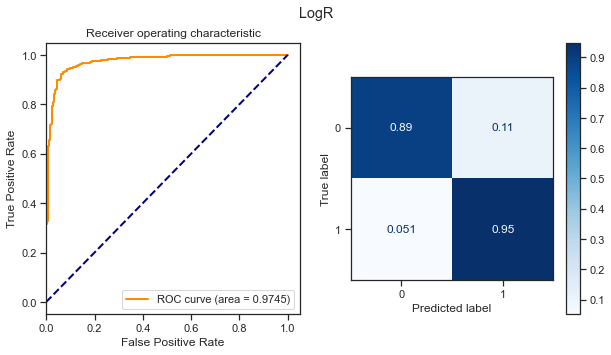

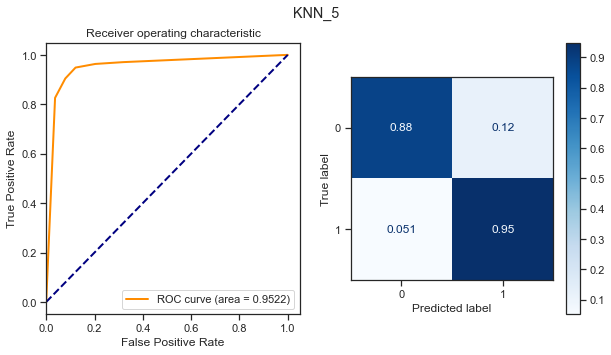

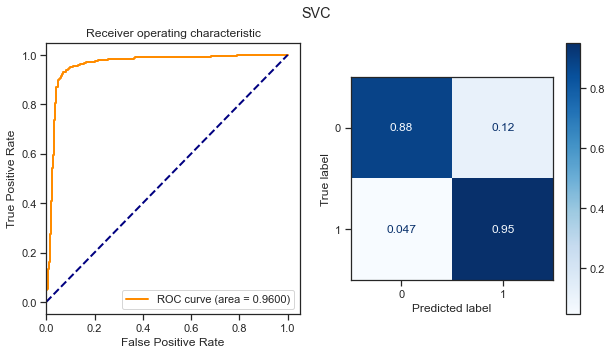

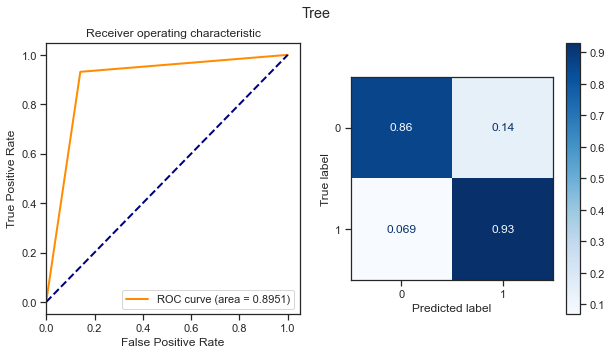

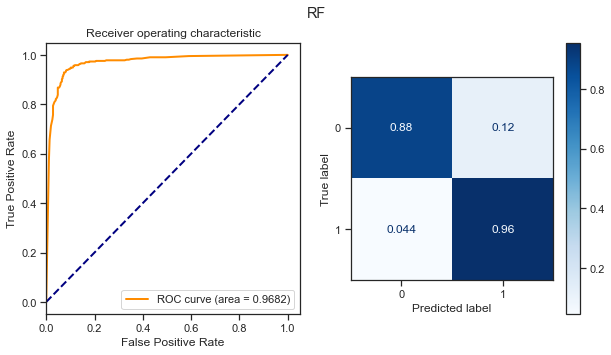

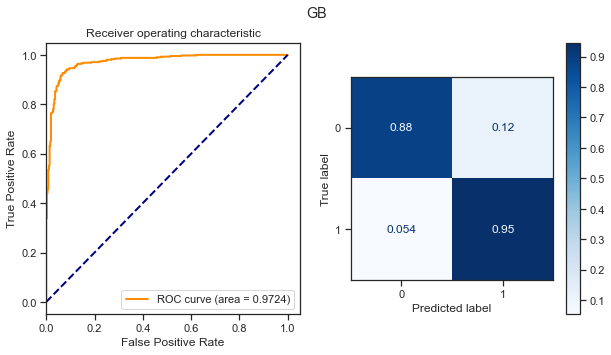

In [32]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

По метрике ROC curve получаем следующие значения:
- Логистическая регрессия: 0.9745
- Метод ближайших соседей (5 соседей): 0.9522
- Машина опорных векторов: 0.96
- Решающее дерево: 0.8951
- Случайный лес: 0.9682
- Градиентный бустинг: 0.9724

В целом все модели показывают хороший результат, однако наиболее успешными моделями оказались модели логистической регрессии и градиентного бустинга.

## Подбор гиперпараметров для выбранных моделей.

In [33]:
# Модели с подобраннами гиперпараметрами
fitted_models = {}

# Функция для подборки гиперпараметров
def tune_model(model, model_name, ranged_parameters):
    clf_gs = GridSearchCV(model, ranged_parameters, cv=5, scoring='roc_auc')
    clf_gs.fit(X_train, Y_train)

    fitted_models[model_name] = clf_gs.best_estimator_

    print('Модель {0}: {1}'.format(clf_gs.best_estimator_, clf_gs.best_score_))
    
    params = clf_gs.cv_results_['params']
    inpt = np.array([list(dic.values()) for dic in params])
    inpt = inpt.swapaxes(0, 1)
    keys = list(ranged_parameters[0].keys())
    if (len(keys) == 2):
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(projection="3d")
        ax.plot_trisurf(*inpt, clf_gs.cv_results_['mean_test_score'])
        ax.set_xlabel(keys[0])
        ax.set_ylabel(keys[1])
        plt.show()
    else:
        plt.plot(*inpt, clf_gs.cv_results_['mean_test_score'])

Модель LogisticRegression(C=1.6000000000000005): 0.9796549943528179


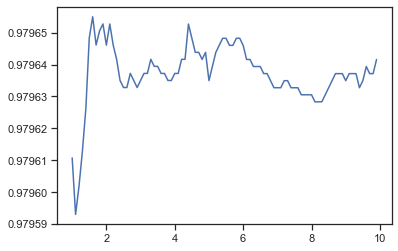

In [34]:
# Logistic Reggression
tune_model(LogisticRegression(), 'LogR_Fitted',
    [{'C': np.arange(start=1, stop=10, step=0.1)}])

Модель KNeighborsClassifier(n_neighbors=83): 0.9787800114060206


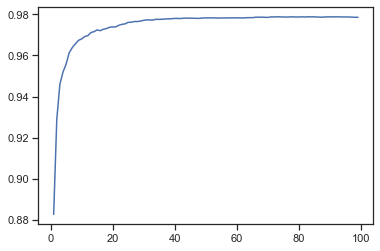

In [35]:
# K Neighbors
tune_model(KNeighborsClassifier(), 'KNN_Fitted', 
    [{'n_neighbors': np.arange(start=1, stop=100, step=1)}])

Модель SVC(probability=True): 0.9711163271726292


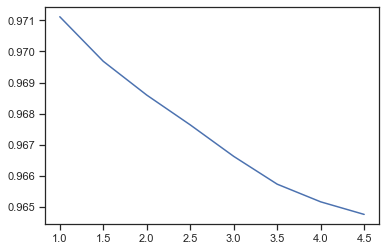

In [36]:
# SVC
tune_model(SVC(probability=True), 'SVC_Fitted', [{'C': np.arange(start=1, stop=5, step=0.5)}])

Модель DecisionTreeClassifier(min_samples_leaf=83, min_samples_split=3): 0.9760235547636238


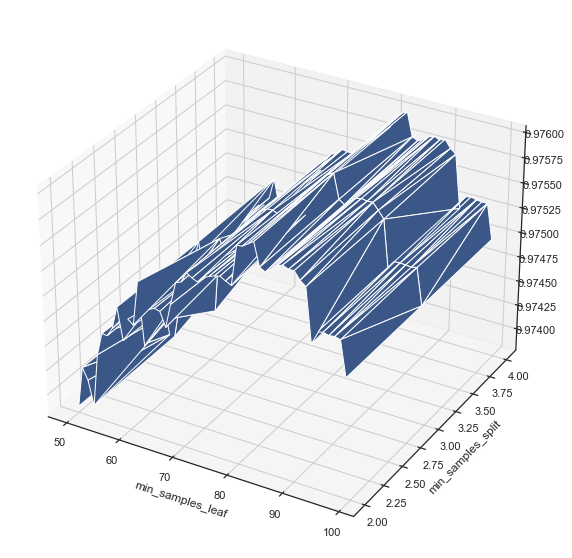

In [37]:
# Tree
tune_model(DecisionTreeClassifier(), 'Tree_Fitted', 
    [{'min_samples_leaf': np.arange(start=50, stop=100, step=1),
      'min_samples_split': np.arange(start=2, stop=5, step=1)}])

Модель RandomForestClassifier(max_depth=4): 0.9793102297177325


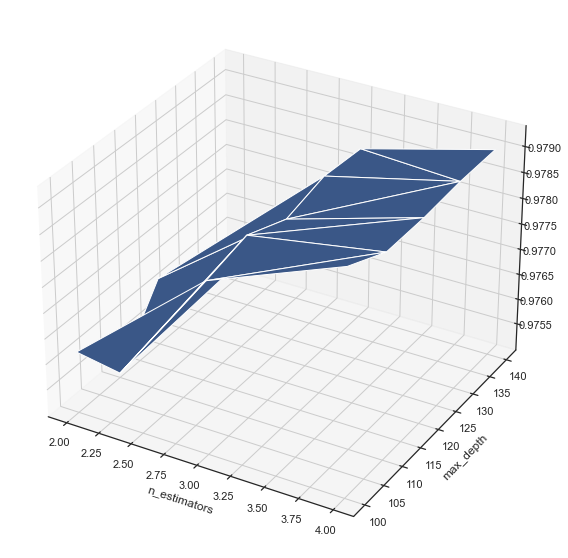

In [38]:
# Random Forest
tune_model(RandomForestClassifier(), 'RF_Fitted',
    [{'n_estimators': np.arange(start=100, stop=150, step=10),
      'max_depth': [2,3,4]}])

Модель GradientBoostingClassifier(): 0.9778839163017597


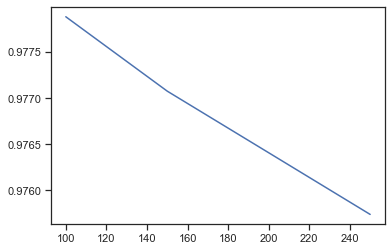

In [39]:
# Gradient Boosting
tune_model(GradientBoostingClassifier(), 'GB_Fitted',
    [{'n_estimators': np.arange(start=100, stop=300, step=50)}])

## Оценка качества новых моделей. Сравнение качества полученных моделей с качеством baseline-моделей.

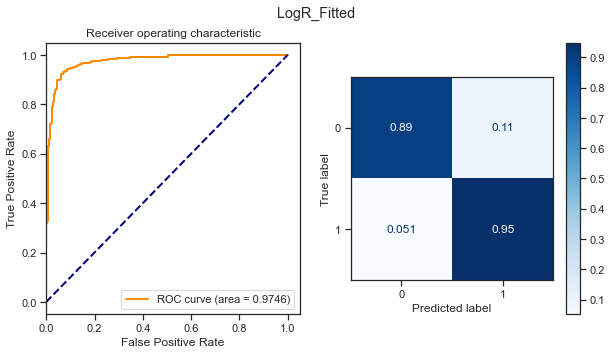

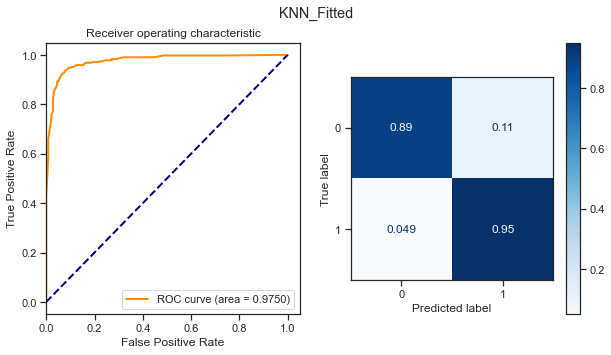

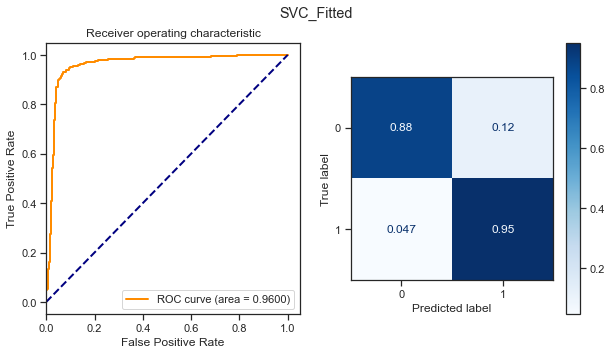

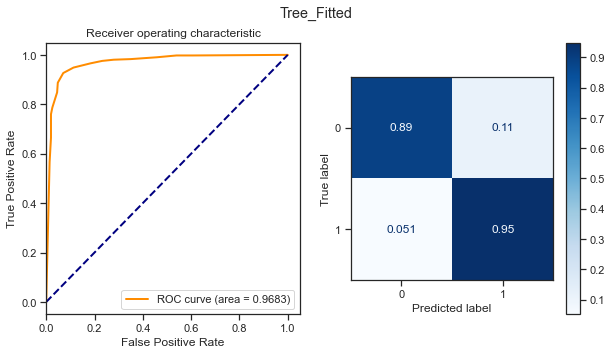

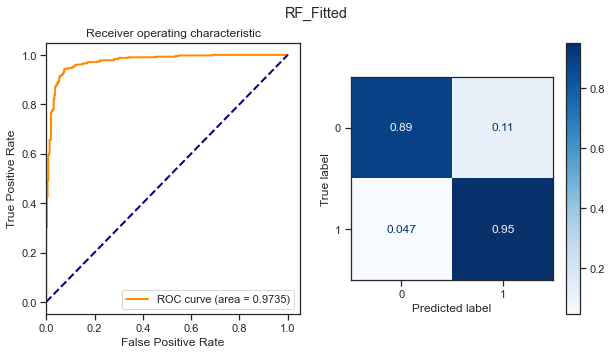

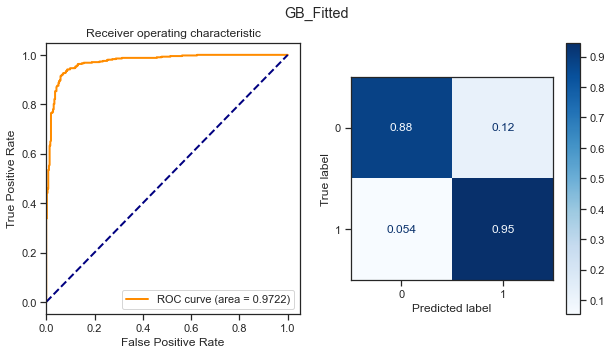

In [40]:
for model_name, model in fitted_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

По метрике ROC curve получаем следующие значения:
- Логистическая регрессия: 0.9746
- Метод ближайших соседей (5 соседей): 0.975
- Машина опорных векторов: 0.96
- Решающее дерево: 0.9683
- Случайный лес: 0.9735
- Градиентный бустинг: 0.9722

## Формирование выводов о качестве построенных моделей на основе выбранных метрик. 

In [41]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

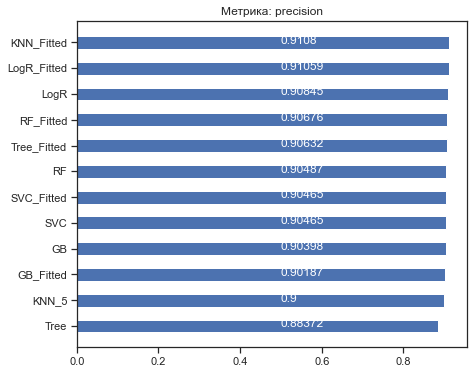

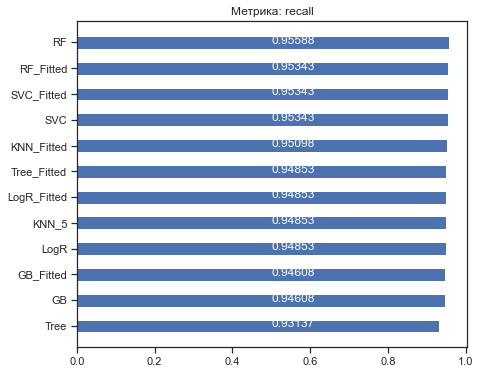

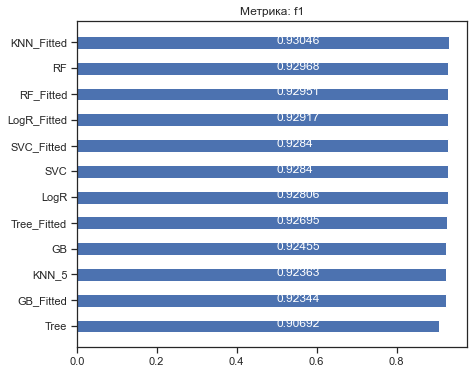

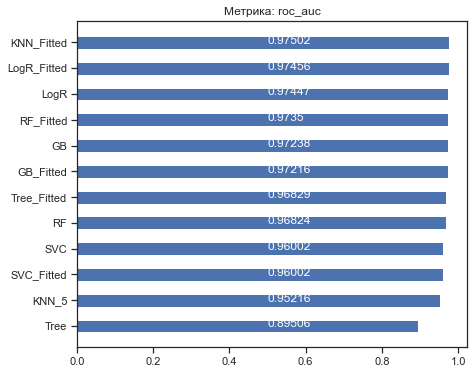

In [42]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

**Вывод: на основании трех метрик из четырех используемых,  лучшей оказалась модель ближайших соседей с числом соседей K = 83.**